# Declarations

In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import yfinance as yf

In [2]:
import seaborn as sns
sns.set_theme(style='darkgrid')

In [4]:
stock_symbol = 'GE'
df = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [30]:
# Separate dates for future plotting
train_dates_df = pd.to_datetime(df.index).to_frame()
train_dates_dt = pd.to_datetime(df.index)
train_dates_sr = pd.to_datetime(df.index).to_series()
# #Separate dates for future plotting
# train_dates = pd.to_datetime(df.index)
# #Variables for training
# cols = list(df)[1:6]
# #Date and volume columns |are not used in training. 
# print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']
# # print(train_dates.tail(15)) #Check last few dates.
# ddf = pd.to_datetime(df.index)
# ddf = ddf.to_frame()
# ddf

In [61]:
# Variables for training 
cols = list(df[["Open","Close","Volume"]])
df_for_training = df[cols].astype(float)

In [62]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled

array([[ 3.50035515,  3.55351149, -0.45050371],
       [ 3.55324668,  3.71818543, -0.36916046],
       [ 3.68129869,  3.60933294, -0.69577741],
       ...,
       [-0.5864077 , -0.53920263, -0.85161715],
       [-0.51692517, -0.57258427, -0.95908714],
       [-0.56577987, -0.62338187, -1.28717507]])

In [68]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 60  # Number of past days we want to use to predict the future.

In [70]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print(type(trainY))
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


<class 'numpy.ndarray'>
trainX shape == (1199, 60, 3).
trainY shape == (1199, 1).


In [105]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

In [76]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10800     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [77]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=70, validation_split=0.1, verbose=1)

Epoch 1/100
16/16 [==============================] - 5s 110ms/step - loss: 5.7300 - val_loss: 0.1091
Epoch 2/100
16/16 [==============================] - 1s 84ms/step - loss: 0.1782 - val_loss: 0.0536
Epoch 3/100
16/16 [==============================] - 1s 86ms/step - loss: 0.1736 - val_loss: 0.0574
Epoch 4/100
16/16 [==============================] - 1s 87ms/step - loss: 0.1183 - val_loss: 0.0845
Epoch 5/100
16/16 [==============================] - 1s 85ms/step - loss: 0.0797 - val_loss: 0.0496
Epoch 6/100
16/16 [==============================] - 1s 84ms/step - loss: 0.0645 - val_loss: 0.0443
Epoch 7/100
16/16 [==============================] - 1s 84ms/step - loss: 0.0635 - val_loss: 0.0388
Epoch 8/100
16/16 [==============================] - 1s 85ms/step - loss: 0.0609 - val_loss: 0.0360
Epoch 9/100
16/16 [==============================] - 1s 86ms/step - loss: 0.0584 - val_loss: 0.0325
Epoch 10/100
16/16 [==============================] - 1s 92ms/step - loss: 0.0584 - val_loss: 0.032

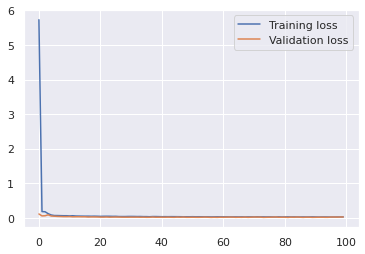

In [87]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [88]:
n_future = 30
forecast_period_dates = pd.date_range(list(train_dates_sr)[-1], periods=n_future, freq='1d')

In [94]:
forecast = model.predict(trainX[-n_future:])

1/1 [==============================] - 0s 404ms/step


In [98]:
# Function to copy value 'N' number of times exactly the number of Columns which we have in 'cols'
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)

In [99]:
# Forecast Prices
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [100]:
# Real prediction prices for the specified 'n_future' period of time
y_pred_future

array([68.4583  , 69.578415, 70.69661 , 71.626656, 73.1523  , 74.134766,
       75.12029 , 75.7733  , 76.41643 , 76.88499 , 77.24687 , 77.445625,
       77.5525  , 77.75331 , 77.97968 , 78.49922 , 79.2564  , 80.0983  ,
       80.9298  , 81.70931 , 82.32049 , 82.63156 , 82.515884, 81.800674,
       80.85483 , 80.01808 , 79.56309 , 79.24584 , 79.01135 , 78.86135 ],
      dtype=float32)

In [101]:
# rework Dates to apply them on the predictions 
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [104]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

/media/dobromir/data/sendbox/MLAC/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/media/dobromir/data/sendbox/MLAC/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Open'>

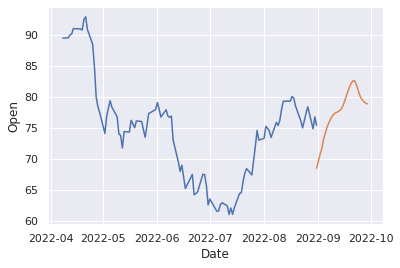

In [114]:
visualization_history = 100
sns.lineplot(df.index[-visualization_history:], df['Open'][-visualization_history:])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])

In [109]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [110]:
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

In [117]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 99ms/step


In [118]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


ValueError: Found array with dim 3. None expected <= 2.

In [80]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
df_forecast['Date']

0    2022-08-08
1    2022-08-09
2    2022-08-10
3    2022-08-11
4    2022-08-12
5    2022-08-15
6    2022-08-16
7    2022-08-17
8    2022-08-18
9    2022-08-19
10   2022-08-22
11   2022-08-23
12   2022-08-24
13   2022-08-25
14   2022-08-26
Name: Date, dtype: datetime64[ns]

/media/dobromir/data/sendbox/MLAC/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Open'>

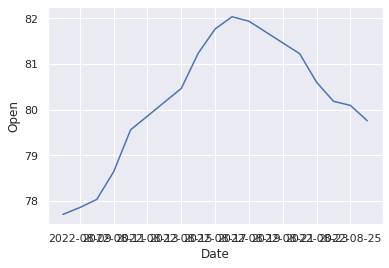

In [93]:
# original = df[['Open']]

# original['Date']=pd.to_datetime(original['Date'])
# original = original.loc[original['Date'] >= '2020-5-1']

# sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])